# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

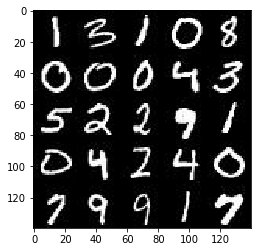

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [3]:
mnist_images.shape

(25, 28, 28, 1)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

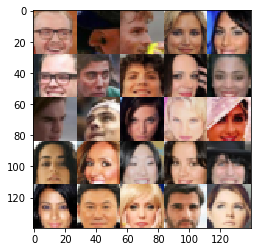

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [5]:
mnist_images.shape

(25, 28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    lr = tf.placeholder(tf.float32, None, name="learning_rate")
    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/user21st/.conda/envs/singulator/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/user21st/.conda/envs/singulator/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/user21st/.conda/envs/singulator/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/user21st/.conda/envs/singulator/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/user21st/.conda/envs/singulator/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start(

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        #print("original image size: ",images.shape)
        # Conv Layer 1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        x1 = tf.maximum(alpha*x1, x1)
        #print("conv1 output image size: ", x1.shape)
        
        # Conv Layer 2
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        #print("conv2 output image size: ", x2.shape)
        
        # Conv Layer 3
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        #print("conv3 output image size: ", x3.shape)
        
        # Flatten
        flat = tf.reshape(x3, (-1, 4*4*256))
        #print("flatten output image size: ", flat.shape)
        logits = tf.layers.dense(flat, 1)
        #print("logits output image size: ", logits.shape)
        out = tf.sigmoid(logits)
        #print("output image size: ", out.shape)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse= not is_train):
        #print("original image size: ",z.shape)
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1,2,2,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        #print("fully connected output image size: ", x1.shape)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="valid")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        #print("TransConv1 output image size: ", x2.shape)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        #print("TransConv2 output image size: ", x3.shape)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding="same")
        #print("TransConv3 output image size: ", logits.shape)

        out= tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z , out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)
        )
    )
    d_loss = d_loss_real  + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    samples, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(
        image_width = width, 
        image_height = height, 
        image_channels = channels, 
        z_dim = z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    print_every = 10
    show_every = 100
    steps = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                #_ = sess.run(net.d_opt, feed_dict={net.in})
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [14]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print('mnist shape = ', mnist_dataset.shape)
print('image mode = ',mnist_dataset.image_mode)
batches = mnist_dataset.get_batches
batches_images = [x for x in batches(128)]
batches_images[0]
#print(batches_images.size)

mnist shape =  (60000, 28, 28, 1)
image mode =  L


array([[[[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ..., 
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]],

        [[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ..., 
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]],

        [[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ..., 
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]],

        ..., 
        [[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ..., 
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]],

        [[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ..., 
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]],

        [[-0.5       ],
         [-0.5       ],
         [-0.5       ],
         ..., 
         [-0.5       ],
         [-0.5       ],
         [-0.5       ]]],


       [[[-0.5    

Epoch 1/2... Discriminator Loss: 1.5725... Generator Loss: 17.7088
Epoch 1/2... Discriminator Loss: 0.4422... Generator Loss: 16.8512
Epoch 1/2... Discriminator Loss: 0.1508... Generator Loss: 3.7135
Epoch 1/2... Discriminator Loss: 6.6263... Generator Loss: 0.0135
Epoch 1/2... Discriminator Loss: 2.2160... Generator Loss: 0.3575
Epoch 1/2... Discriminator Loss: 0.5090... Generator Loss: 2.7220
Epoch 1/2... Discriminator Loss: 0.6372... Generator Loss: 0.9431
Epoch 1/2... Discriminator Loss: 0.3319... Generator Loss: 1.5316
Epoch 1/2... Discriminator Loss: 2.9750... Generator Loss: 0.0982
Epoch 1/2... Discriminator Loss: 0.2458... Generator Loss: 2.1332


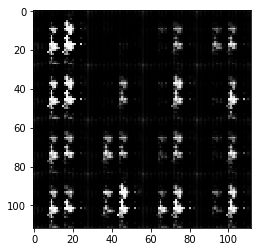

Epoch 1/2... Discriminator Loss: 0.1688... Generator Loss: 3.0465
Epoch 1/2... Discriminator Loss: 1.8990... Generator Loss: 8.5733
Epoch 1/2... Discriminator Loss: 0.4552... Generator Loss: 1.4469
Epoch 1/2... Discriminator Loss: 0.1745... Generator Loss: 4.0457
Epoch 1/2... Discriminator Loss: 2.1252... Generator Loss: 0.2046
Epoch 1/2... Discriminator Loss: 0.3675... Generator Loss: 2.3747
Epoch 1/2... Discriminator Loss: 0.5934... Generator Loss: 2.0850
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 1.3552
Epoch 1/2... Discriminator Loss: 1.5834... Generator Loss: 0.4806
Epoch 1/2... Discriminator Loss: 1.9942... Generator Loss: 5.9379


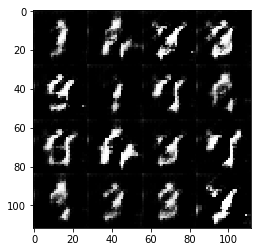

Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 2.9472
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.6351
Epoch 1/2... Discriminator Loss: 0.6662... Generator Loss: 1.2895
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 4.5683
Epoch 1/2... Discriminator Loss: 0.7339... Generator Loss: 1.8153
Epoch 1/2... Discriminator Loss: 0.4123... Generator Loss: 1.9944
Epoch 1/2... Discriminator Loss: 0.5371... Generator Loss: 1.5859
Epoch 1/2... Discriminator Loss: 0.6779... Generator Loss: 2.7710
Epoch 1/2... Discriminator Loss: 1.1363... Generator Loss: 1.1292
Epoch 1/2... Discriminator Loss: 0.7698... Generator Loss: 2.3297


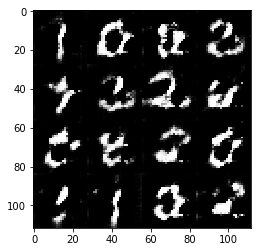

Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 2.2709
Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 1.1219
Epoch 1/2... Discriminator Loss: 1.6208... Generator Loss: 0.4059
Epoch 1/2... Discriminator Loss: 0.5307... Generator Loss: 1.5108
Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 0.6298... Generator Loss: 1.7714
Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 1.5631... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 1.2306
Epoch 1/2... Discriminator Loss: 1.7042... Generator Loss: 0.3994


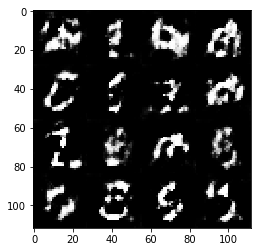

Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 1.3600
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 1.9548
Epoch 1/2... Discriminator Loss: 1.3020... Generator Loss: 0.6668
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.4473
Epoch 1/2... Discriminator Loss: 1.1698... Generator Loss: 2.5219
Epoch 1/2... Discriminator Loss: 1.0898... Generator Loss: 2.3275
Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 2.0282
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 1.5566
Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 1.4268... Generator Loss: 0.5356


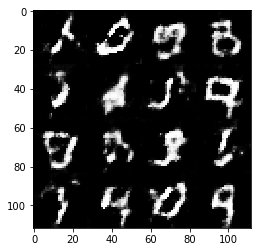

Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 1.4707
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 1.7842
Epoch 1/2... Discriminator Loss: 1.2664... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 0.8331... Generator Loss: 1.7485
Epoch 1/2... Discriminator Loss: 0.9136... Generator Loss: 1.0400
Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.9682
Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 1.3393
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 0.8182
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.9713


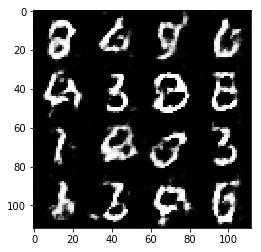

Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.5367
Epoch 1/2... Discriminator Loss: 1.5557... Generator Loss: 0.3871
Epoch 1/2... Discriminator Loss: 1.0924... Generator Loss: 0.6032
Epoch 1/2... Discriminator Loss: 0.7758... Generator Loss: 1.3840
Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 0.5468
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 2.1560
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 0.9126
Epoch 1/2... Discriminator Loss: 1.1410... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 0.6586


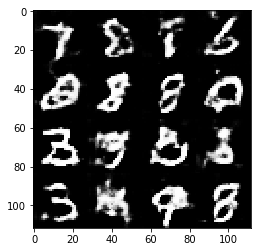

Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.5470
Epoch 1/2... Discriminator Loss: 1.0453... Generator Loss: 0.6897
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 1.3930
Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 1.0330
Epoch 1/2... Discriminator Loss: 0.9754... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 1.6983
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 0.5192
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.5088
Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.5004
Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 0.4359


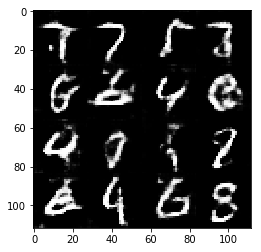

Epoch 1/2... Discriminator Loss: 0.9337... Generator Loss: 1.5899
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.1972
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.6140
Epoch 1/2... Discriminator Loss: 1.0996... Generator Loss: 0.8751
Epoch 1/2... Discriminator Loss: 1.5433... Generator Loss: 0.3443
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 0.9066
Epoch 1/2... Discriminator Loss: 0.9396... Generator Loss: 1.4760
Epoch 1/2... Discriminator Loss: 1.6438... Generator Loss: 0.3003
Epoch 1/2... Discriminator Loss: 0.7508... Generator Loss: 1.1580
Epoch 1/2... Discriminator Loss: 1.5079... Generator Loss: 0.4366


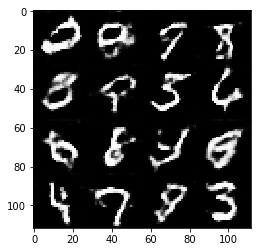

Epoch 1/2... Discriminator Loss: 1.7922... Generator Loss: 0.3126
Epoch 1/2... Discriminator Loss: 1.4270... Generator Loss: 0.3907
Epoch 1/2... Discriminator Loss: 1.1594... Generator Loss: 0.6375
Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 0.5794
Epoch 1/2... Discriminator Loss: 0.9504... Generator Loss: 0.8890
Epoch 1/2... Discriminator Loss: 1.2783... Generator Loss: 0.4741
Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.1834
Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 0.7600


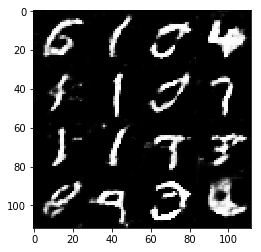

Epoch 1/2... Discriminator Loss: 1.2996... Generator Loss: 2.0803
Epoch 1/2... Discriminator Loss: 1.5272... Generator Loss: 0.3570
Epoch 1/2... Discriminator Loss: 1.8655... Generator Loss: 0.2360
Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 0.9966
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 1.3431
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 1.3351
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.0731
Epoch 1/2... Discriminator Loss: 1.0058... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 0.5239


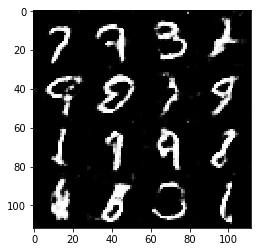

Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 0.4122
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.3894
Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 0.7281
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.5275
Epoch 1/2... Discriminator Loss: 1.5585... Generator Loss: 0.3198
Epoch 1/2... Discriminator Loss: 1.8569... Generator Loss: 0.2374
Epoch 1/2... Discriminator Loss: 1.6211... Generator Loss: 0.3447
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.3968
Epoch 1/2... Discriminator Loss: 0.7433... Generator Loss: 1.0144
Epoch 1/2... Discriminator Loss: 2.2833... Generator Loss: 0.1477


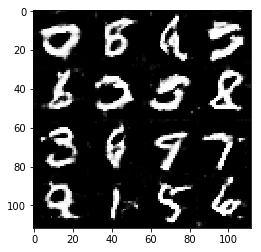

Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 0.7260
Epoch 1/2... Discriminator Loss: 1.9061... Generator Loss: 0.2206
Epoch 1/2... Discriminator Loss: 0.8206... Generator Loss: 0.9236
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 2.0749
Epoch 1/2... Discriminator Loss: 0.7765... Generator Loss: 1.0232
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.6917
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 1.6299
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 1.3486
Epoch 1/2... Discriminator Loss: 0.7186... Generator Loss: 1.4715
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 2.6539


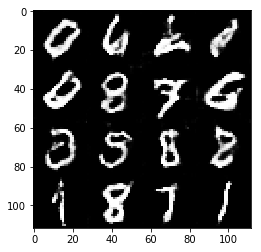

Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.7329
Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 1.8739
Epoch 1/2... Discriminator Loss: 0.7548... Generator Loss: 1.3121
Epoch 1/2... Discriminator Loss: 0.7292... Generator Loss: 1.7336
Epoch 1/2... Discriminator Loss: 2.0486... Generator Loss: 0.1684
Epoch 1/2... Discriminator Loss: 0.7946... Generator Loss: 1.3272
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.4180
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 0.6455
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 1.1097


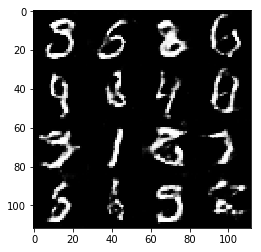

Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 0.6130
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 0.6566... Generator Loss: 1.4116
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 0.8930
Epoch 1/2... Discriminator Loss: 1.1689... Generator Loss: 0.5560
Epoch 1/2... Discriminator Loss: 1.5709... Generator Loss: 0.3597
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 1.0680
Epoch 1/2... Discriminator Loss: 1.4920... Generator Loss: 0.3391
Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 0.5314


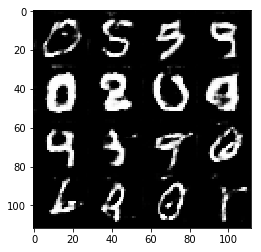

Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 0.7117
Epoch 1/2... Discriminator Loss: 0.5799... Generator Loss: 1.7771
Epoch 1/2... Discriminator Loss: 2.6949... Generator Loss: 0.1049
Epoch 1/2... Discriminator Loss: 1.2005... Generator Loss: 2.7633
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.4945
Epoch 1/2... Discriminator Loss: 0.7752... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 1.5050... Generator Loss: 0.3452
Epoch 1/2... Discriminator Loss: 0.8526... Generator Loss: 2.1435


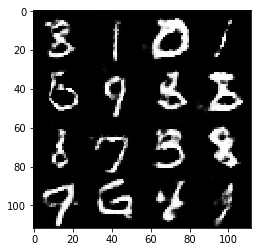

Epoch 1/2... Discriminator Loss: 1.6016... Generator Loss: 0.3027
Epoch 1/2... Discriminator Loss: 0.4424... Generator Loss: 1.4448
Epoch 1/2... Discriminator Loss: 0.5739... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 1.0392... Generator Loss: 2.5515
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 0.5990
Epoch 1/2... Discriminator Loss: 0.6293... Generator Loss: 1.6346
Epoch 1/2... Discriminator Loss: 2.1001... Generator Loss: 0.2352
Epoch 1/2... Discriminator Loss: 2.4016... Generator Loss: 0.2093
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 0.5660
Epoch 1/2... Discriminator Loss: 0.8861... Generator Loss: 0.8438


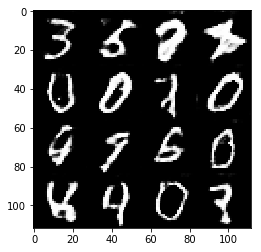

Epoch 1/2... Discriminator Loss: 2.1669... Generator Loss: 0.1783
Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 1.0112
Epoch 1/2... Discriminator Loss: 0.3125... Generator Loss: 1.7643
Epoch 1/2... Discriminator Loss: 5.1933... Generator Loss: 0.0189
Epoch 1/2... Discriminator Loss: 1.9248... Generator Loss: 0.2937
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 0.5319
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.6216
Epoch 1/2... Discriminator Loss: 1.4756... Generator Loss: 0.4255
Epoch 1/2... Discriminator Loss: 1.6270... Generator Loss: 0.3666


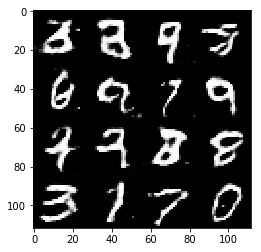

Epoch 1/2... Discriminator Loss: 0.8076... Generator Loss: 1.0334
Epoch 1/2... Discriminator Loss: 0.5333... Generator Loss: 2.0386
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 3.1087
Epoch 1/2... Discriminator Loss: 0.7605... Generator Loss: 0.9011
Epoch 1/2... Discriminator Loss: 0.3913... Generator Loss: 2.1017
Epoch 1/2... Discriminator Loss: 2.6038... Generator Loss: 0.1212
Epoch 1/2... Discriminator Loss: 0.6256... Generator Loss: 1.0530
Epoch 2/2... Discriminator Loss: 2.5361... Generator Loss: 0.2228
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.5150
Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 0.8677


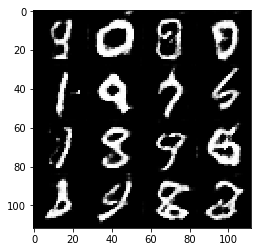

Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 0.6081
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.5858
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 2.0262
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 2.4424
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 0.5902... Generator Loss: 2.2939
Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 1.0079... Generator Loss: 2.1321
Epoch 2/2... Discriminator Loss: 0.6144... Generator Loss: 1.3644
Epoch 2/2... Discriminator Loss: 0.6030... Generator Loss: 1.1496


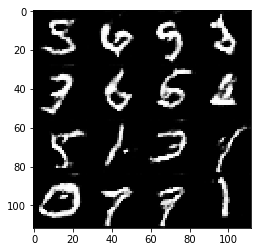

Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 3.3203
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.5068
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.5840
Epoch 2/2... Discriminator Loss: 0.5985... Generator Loss: 1.0685
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 1.0785... Generator Loss: 2.1452
Epoch 2/2... Discriminator Loss: 0.6448... Generator Loss: 1.4970
Epoch 2/2... Discriminator Loss: 0.7514... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 0.3957... Generator Loss: 1.3549
Epoch 2/2... Discriminator Loss: 3.8953... Generator Loss: 0.0379


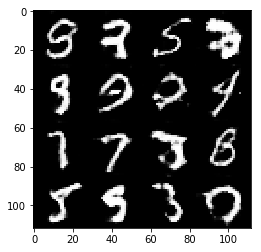

Epoch 2/2... Discriminator Loss: 1.0489... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 0.6639
Epoch 2/2... Discriminator Loss: 1.4741... Generator Loss: 0.4053
Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 2.0365... Generator Loss: 0.2144
Epoch 2/2... Discriminator Loss: 0.7182... Generator Loss: 1.4542
Epoch 2/2... Discriminator Loss: 0.6624... Generator Loss: 1.0409
Epoch 2/2... Discriminator Loss: 1.5415... Generator Loss: 0.3628
Epoch 2/2... Discriminator Loss: 0.5325... Generator Loss: 1.3382


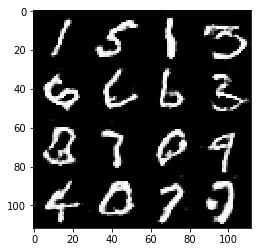

Epoch 2/2... Discriminator Loss: 0.6668... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 0.8772... Generator Loss: 0.9226
Epoch 2/2... Discriminator Loss: 0.6827... Generator Loss: 1.7179
Epoch 2/2... Discriminator Loss: 0.7374... Generator Loss: 0.8669
Epoch 2/2... Discriminator Loss: 0.7819... Generator Loss: 0.9549
Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 1.0732... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 0.8935... Generator Loss: 0.7438
Epoch 2/2... Discriminator Loss: 0.7061... Generator Loss: 2.4644
Epoch 2/2... Discriminator Loss: 0.6776... Generator Loss: 2.5386


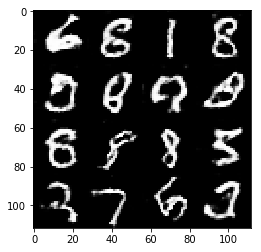

Epoch 2/2... Discriminator Loss: 1.4694... Generator Loss: 4.3931
Epoch 2/2... Discriminator Loss: 0.7721... Generator Loss: 2.6684
Epoch 2/2... Discriminator Loss: 0.6179... Generator Loss: 1.1381
Epoch 2/2... Discriminator Loss: 2.1415... Generator Loss: 0.2366
Epoch 2/2... Discriminator Loss: 0.4396... Generator Loss: 1.3790
Epoch 2/2... Discriminator Loss: 0.2378... Generator Loss: 2.1456
Epoch 2/2... Discriminator Loss: 0.5079... Generator Loss: 2.4475
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 0.8080... Generator Loss: 0.9907
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.5986


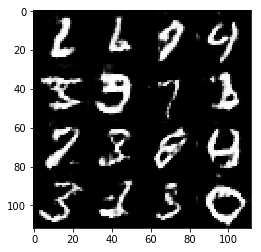

Epoch 2/2... Discriminator Loss: 0.4525... Generator Loss: 2.4727
Epoch 2/2... Discriminator Loss: 1.4006... Generator Loss: 3.7260
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 0.5686
Epoch 2/2... Discriminator Loss: 0.4150... Generator Loss: 1.8234
Epoch 2/2... Discriminator Loss: 0.5034... Generator Loss: 1.3295
Epoch 2/2... Discriminator Loss: 2.0315... Generator Loss: 0.2245
Epoch 2/2... Discriminator Loss: 0.2197... Generator Loss: 2.0647
Epoch 2/2... Discriminator Loss: 0.2592... Generator Loss: 2.0509
Epoch 2/2... Discriminator Loss: 0.4942... Generator Loss: 1.2463
Epoch 2/2... Discriminator Loss: 0.4476... Generator Loss: 1.4124


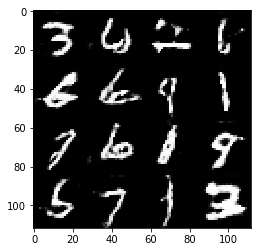

Epoch 2/2... Discriminator Loss: 0.4718... Generator Loss: 1.7504
Epoch 2/2... Discriminator Loss: 0.6699... Generator Loss: 1.0610
Epoch 2/2... Discriminator Loss: 0.8818... Generator Loss: 1.0009
Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 0.5122
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.5191
Epoch 2/2... Discriminator Loss: 2.0773... Generator Loss: 4.0313
Epoch 2/2... Discriminator Loss: 0.6426... Generator Loss: 1.9960
Epoch 2/2... Discriminator Loss: 0.4753... Generator Loss: 2.0944
Epoch 2/2... Discriminator Loss: 0.6192... Generator Loss: 1.2262
Epoch 2/2... Discriminator Loss: 0.4996... Generator Loss: 1.4174


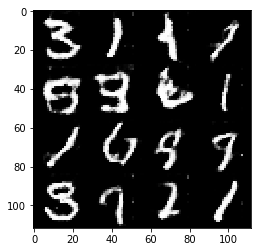

Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.4695... Generator Loss: 3.6631
Epoch 2/2... Discriminator Loss: 0.7097... Generator Loss: 1.5254
Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 0.9321
Epoch 2/2... Discriminator Loss: 1.5311... Generator Loss: 0.5133
Epoch 2/2... Discriminator Loss: 0.4539... Generator Loss: 1.7234
Epoch 2/2... Discriminator Loss: 0.7489... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 2.8437
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 0.6429
Epoch 2/2... Discriminator Loss: 0.8019... Generator Loss: 1.3289


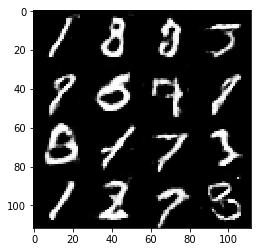

Epoch 2/2... Discriminator Loss: 0.8434... Generator Loss: 1.0854
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 1.0467
Epoch 2/2... Discriminator Loss: 0.9830... Generator Loss: 0.7972
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 0.5542... Generator Loss: 1.8364
Epoch 2/2... Discriminator Loss: 1.4424... Generator Loss: 0.4453
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 2.2927... Generator Loss: 0.1839
Epoch 2/2... Discriminator Loss: 1.3365... Generator Loss: 0.5129
Epoch 2/2... Discriminator Loss: 1.8679... Generator Loss: 0.2986


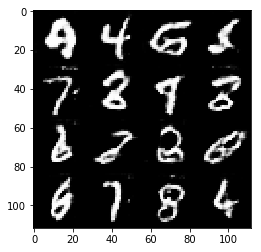

Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 0.4433... Generator Loss: 1.5009
Epoch 2/2... Discriminator Loss: 0.2876... Generator Loss: 1.9392
Epoch 2/2... Discriminator Loss: 0.4179... Generator Loss: 1.4340
Epoch 2/2... Discriminator Loss: 0.6941... Generator Loss: 1.0167
Epoch 2/2... Discriminator Loss: 0.3684... Generator Loss: 1.5942
Epoch 2/2... Discriminator Loss: 0.4416... Generator Loss: 2.1900
Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 0.4442
Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 1.1074
Epoch 2/2... Discriminator Loss: 0.8121... Generator Loss: 0.9950


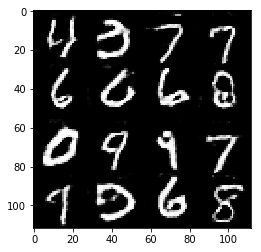

Epoch 2/2... Discriminator Loss: 1.0756... Generator Loss: 0.7363
Epoch 2/2... Discriminator Loss: 0.5891... Generator Loss: 3.2313
Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 0.5967
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 0.4754
Epoch 2/2... Discriminator Loss: 0.6921... Generator Loss: 1.2173
Epoch 2/2... Discriminator Loss: 0.3946... Generator Loss: 1.4595
Epoch 2/2... Discriminator Loss: 0.8496... Generator Loss: 0.8094
Epoch 2/2... Discriminator Loss: 0.6081... Generator Loss: 1.2309
Epoch 2/2... Discriminator Loss: 0.6234... Generator Loss: 1.1296
Epoch 2/2... Discriminator Loss: 0.3629... Generator Loss: 1.8173


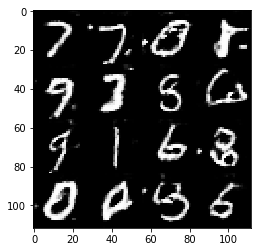

Epoch 2/2... Discriminator Loss: 0.5802... Generator Loss: 1.1614
Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 1.6426
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 1.0579
Epoch 2/2... Discriminator Loss: 0.6411... Generator Loss: 0.9469
Epoch 2/2... Discriminator Loss: 1.6402... Generator Loss: 0.5905
Epoch 2/2... Discriminator Loss: 0.6825... Generator Loss: 1.3505
Epoch 2/2... Discriminator Loss: 0.7605... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 0.8212... Generator Loss: 0.7975
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 2.8489
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.5324


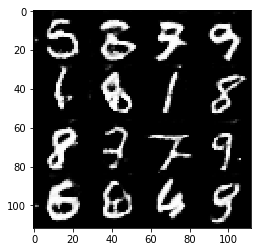

Epoch 2/2... Discriminator Loss: 0.5368... Generator Loss: 1.3910
Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 1.7646
Epoch 2/2... Discriminator Loss: 0.4073... Generator Loss: 1.8993
Epoch 2/2... Discriminator Loss: 0.6940... Generator Loss: 1.0706
Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 0.7614
Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 1.8070
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 0.4603
Epoch 2/2... Discriminator Loss: 0.5741... Generator Loss: 1.3323
Epoch 2/2... Discriminator Loss: 1.7592... Generator Loss: 0.4251
Epoch 2/2... Discriminator Loss: 0.3561... Generator Loss: 1.5766


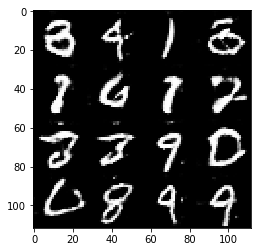

Epoch 2/2... Discriminator Loss: 1.8706... Generator Loss: 0.3027
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 2.1020
Epoch 2/2... Discriminator Loss: 0.6409... Generator Loss: 1.5912
Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 1.3283
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 3.1848
Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 1.1450
Epoch 2/2... Discriminator Loss: 0.4763... Generator Loss: 1.3984
Epoch 2/2... Discriminator Loss: 0.4472... Generator Loss: 1.4440
Epoch 2/2... Discriminator Loss: 0.4896... Generator Loss: 1.3559
Epoch 2/2... Discriminator Loss: 1.3116... Generator Loss: 0.5020


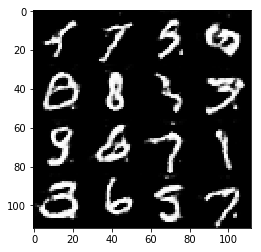

Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 0.3317... Generator Loss: 2.6061
Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 0.9077
Epoch 2/2... Discriminator Loss: 0.7255... Generator Loss: 1.2363
Epoch 2/2... Discriminator Loss: 0.6190... Generator Loss: 1.0113
Epoch 2/2... Discriminator Loss: 1.0392... Generator Loss: 0.5916
Epoch 2/2... Discriminator Loss: 0.4691... Generator Loss: 1.3478
Epoch 2/2... Discriminator Loss: 0.4443... Generator Loss: 1.4677
Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 0.8137
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 0.7525


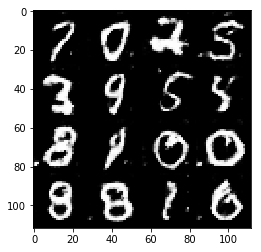

Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 0.4873... Generator Loss: 1.2855
Epoch 2/2... Discriminator Loss: 2.5613... Generator Loss: 0.1892
Epoch 2/2... Discriminator Loss: 1.0398... Generator Loss: 0.7135
Epoch 2/2... Discriminator Loss: 0.7285... Generator Loss: 0.9087
Epoch 2/2... Discriminator Loss: 1.8497... Generator Loss: 0.2710
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 0.7717
Epoch 2/2... Discriminator Loss: 0.3345... Generator Loss: 1.8175
Epoch 2/2... Discriminator Loss: 1.6171... Generator Loss: 0.3357
Epoch 2/2... Discriminator Loss: 0.3638... Generator Loss: 2.7171


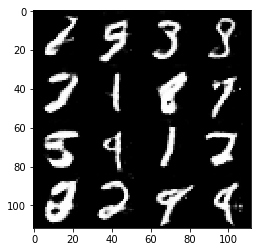

Epoch 2/2... Discriminator Loss: 0.5609... Generator Loss: 1.8299
Epoch 2/2... Discriminator Loss: 0.6513... Generator Loss: 4.3416
Epoch 2/2... Discriminator Loss: 2.1907... Generator Loss: 0.2624
Epoch 2/2... Discriminator Loss: 0.2693... Generator Loss: 2.8478
Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 0.9087
Epoch 2/2... Discriminator Loss: 0.6291... Generator Loss: 1.5123
Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 1.0767
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 0.3277... Generator Loss: 1.7751


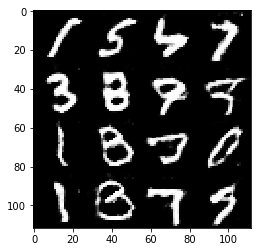

Epoch 2/2... Discriminator Loss: 0.8663... Generator Loss: 0.7376
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 0.6273... Generator Loss: 1.0814
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 1.0459
Epoch 2/2... Discriminator Loss: 1.4970... Generator Loss: 0.4530
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 2.3252... Generator Loss: 4.3098
Epoch 2/2... Discriminator Loss: 0.5587... Generator Loss: 1.5433
Epoch 2/2... Discriminator Loss: 1.6410... Generator Loss: 0.3313
Epoch 2/2... Discriminator Loss: 0.9714... Generator Loss: 0.8149


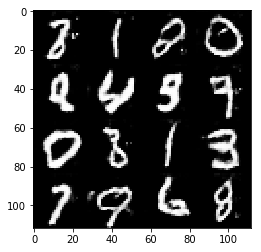

Epoch 2/2... Discriminator Loss: 0.4662... Generator Loss: 1.5270
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 1.0140
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.5159
Epoch 2/2... Discriminator Loss: 1.5890... Generator Loss: 5.2603
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 1.5152


In [15]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8326... Generator Loss: 0.3295
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 1.3512
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 1.5528
Epoch 1/1... Discriminator Loss: 0.2059... Generator Loss: 2.0994
Epoch 1/1... Discriminator Loss: 0.4809... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 0.4099... Generator Loss: 4.8084
Epoch 1/1... Discriminator Loss: 0.2424... Generator Loss: 2.7788
Epoch 1/1... Discriminator Loss: 0.3449... Generator Loss: 2.0680


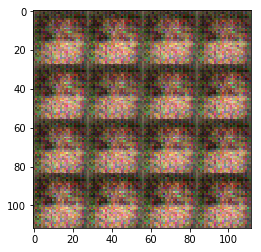

Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 3.0995
Epoch 1/1... Discriminator Loss: 0.2393... Generator Loss: 2.3211
Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 0.3171... Generator Loss: 1.9373
Epoch 1/1... Discriminator Loss: 0.1070... Generator Loss: 2.9041
Epoch 1/1... Discriminator Loss: 0.2717... Generator Loss: 3.9104
Epoch 1/1... Discriminator Loss: 0.1581... Generator Loss: 2.4589
Epoch 1/1... Discriminator Loss: 0.0550... Generator Loss: 3.5570
Epoch 1/1... Discriminator Loss: 0.1945... Generator Loss: 2.3933
Epoch 1/1... Discriminator Loss: 0.0876... Generator Loss: 2.8669


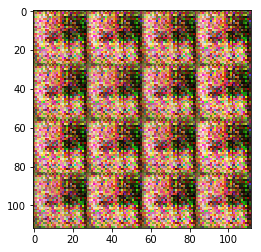

Epoch 1/1... Discriminator Loss: 0.0666... Generator Loss: 2.9526
Epoch 1/1... Discriminator Loss: 0.1365... Generator Loss: 2.7010
Epoch 1/1... Discriminator Loss: 0.1398... Generator Loss: 2.7597
Epoch 1/1... Discriminator Loss: 0.0579... Generator Loss: 3.1710
Epoch 1/1... Discriminator Loss: 0.1421... Generator Loss: 2.8433
Epoch 1/1... Discriminator Loss: 0.0964... Generator Loss: 2.7866
Epoch 1/1... Discriminator Loss: 0.1091... Generator Loss: 3.1968
Epoch 1/1... Discriminator Loss: 0.0595... Generator Loss: 3.2914
Epoch 1/1... Discriminator Loss: 0.2659... Generator Loss: 2.3803
Epoch 1/1... Discriminator Loss: 0.1779... Generator Loss: 2.8159


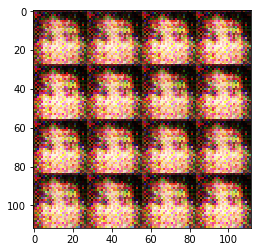

Epoch 1/1... Discriminator Loss: 0.1739... Generator Loss: 6.1190
Epoch 1/1... Discriminator Loss: 0.1196... Generator Loss: 3.0715
Epoch 1/1... Discriminator Loss: 0.0816... Generator Loss: 3.1048
Epoch 1/1... Discriminator Loss: 0.0941... Generator Loss: 3.0955
Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 3.3063
Epoch 1/1... Discriminator Loss: 0.0724... Generator Loss: 3.3858
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 2.8224
Epoch 1/1... Discriminator Loss: 0.0958... Generator Loss: 3.3139
Epoch 1/1... Discriminator Loss: 0.1519... Generator Loss: 2.7731
Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 2.4305


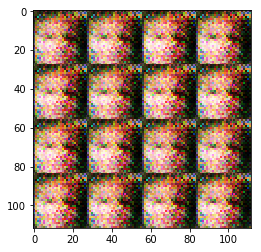

Epoch 1/1... Discriminator Loss: 0.1601... Generator Loss: 2.6188
Epoch 1/1... Discriminator Loss: 0.1418... Generator Loss: 2.4048
Epoch 1/1... Discriminator Loss: 0.0686... Generator Loss: 7.0765
Epoch 1/1... Discriminator Loss: 0.2453... Generator Loss: 1.8525
Epoch 1/1... Discriminator Loss: 0.2032... Generator Loss: 2.1412
Epoch 1/1... Discriminator Loss: 0.0508... Generator Loss: 3.5064
Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 3.6555
Epoch 1/1... Discriminator Loss: 0.1086... Generator Loss: 3.1288
Epoch 1/1... Discriminator Loss: 0.4315... Generator Loss: 2.1213
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 3.6121


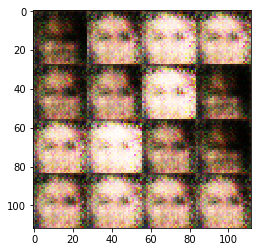

Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 4.6003
Epoch 1/1... Discriminator Loss: 0.5666... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 1.6706
Epoch 1/1... Discriminator Loss: 0.3216... Generator Loss: 1.8625
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 0.2888... Generator Loss: 3.5590
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 0.3908... Generator Loss: 2.2473
Epoch 1/1... Discriminator Loss: 0.3726... Generator Loss: 1.4294


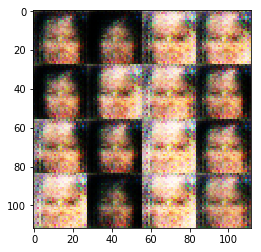

Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.6490
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 3.5632
Epoch 1/1... Discriminator Loss: 0.2752... Generator Loss: 2.3541
Epoch 1/1... Discriminator Loss: 0.5318... Generator Loss: 2.0616
Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 1.8627
Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 4.0922
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 3.4161
Epoch 1/1... Discriminator Loss: 0.4342... Generator Loss: 2.0379
Epoch 1/1... Discriminator Loss: 0.4116... Generator Loss: 1.8630


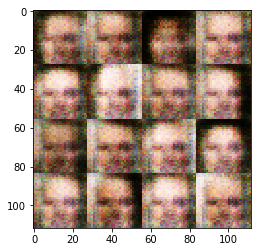

Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 1.8553
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 2.0299
Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 2.8047
Epoch 1/1... Discriminator Loss: 0.5110... Generator Loss: 2.6164
Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 1.2335
Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 2.1261


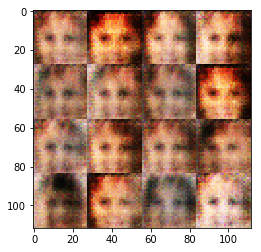

Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 1.7400
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 3.0168
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 1.4371
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 2.6669
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.3827
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 1.3735
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 2.0023
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.0459


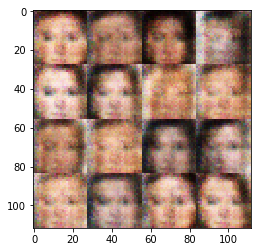

Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 2.1508
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 2.0043


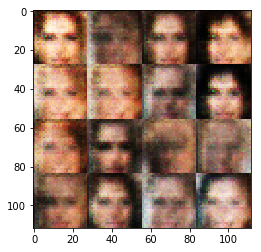

Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.6947
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.9761
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.2645


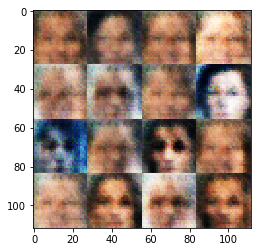

Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 1.3452
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.4482
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.4197
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 1.8920


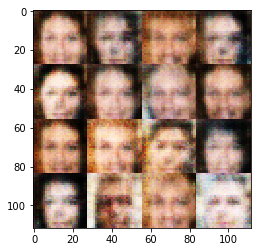

Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.3297
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.5012
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 1.2271


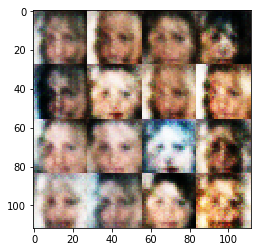

Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.4772


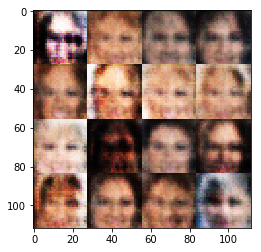

Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 1.3255
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.2400
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.8737


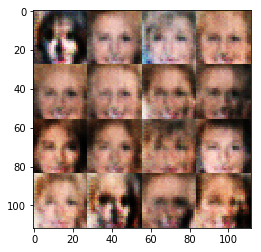

Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.7290
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.0393
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.9186


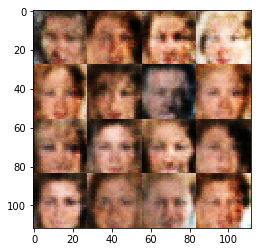

Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.1834
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 1.6749
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 1.4373
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 0.7546


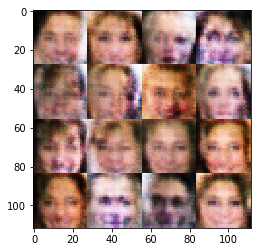

Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.7355
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.7761
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.9584


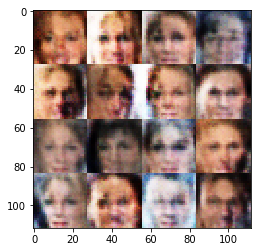

Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.7466


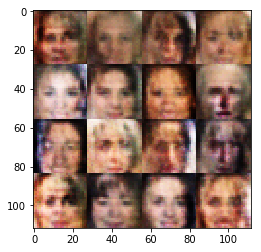

Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.3046
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.6619


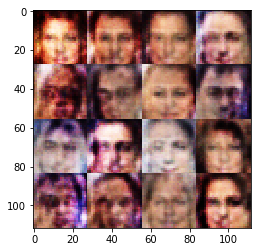

Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.9236


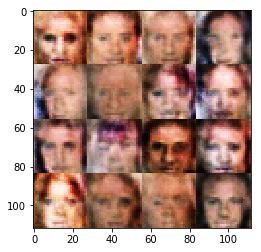

Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.6133
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.5134


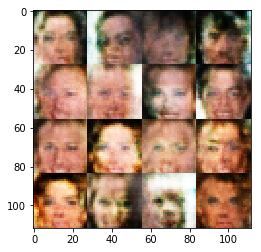

Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.2658
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.2836
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 0.8888


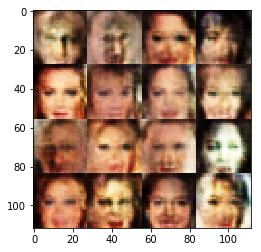

Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.5085
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 1.5363
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 1.3076


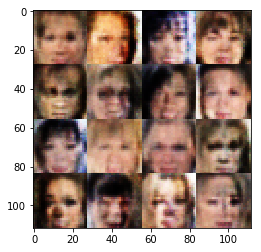

Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 0.8160... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.6117


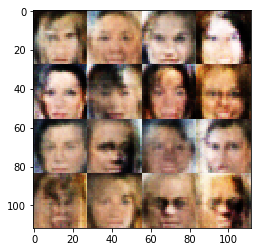

Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.5029
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.2570


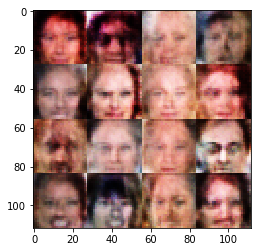

Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 1.5771
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 0.8860


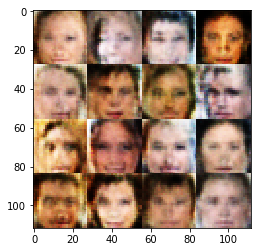

Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.2850
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.2786


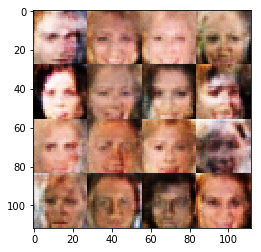

Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.3763
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.3470


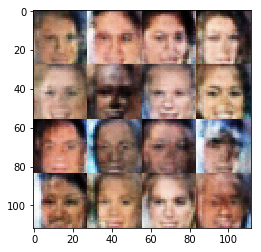

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 1.3740
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 0.6623... Generator Loss: 1.5470
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.7943


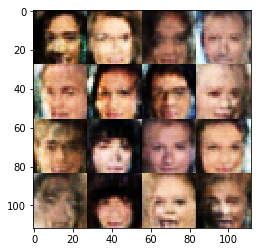

Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.6646


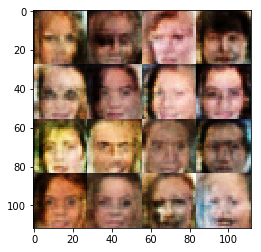

Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.2906
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.4603


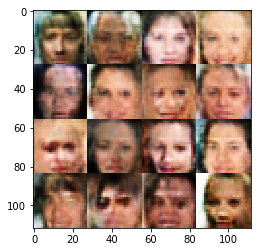

Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 0.6127... Generator Loss: 1.4429
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 0.6421... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.2059


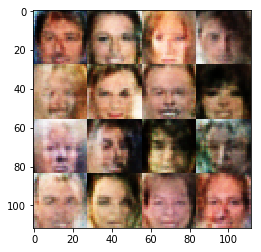

Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.2518
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.6478


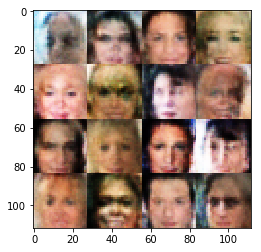

Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 1.8264


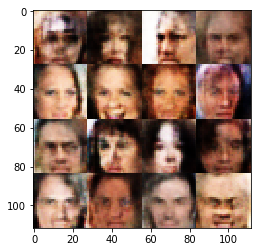

Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 1.6029


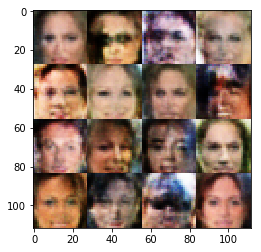

Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 1.3415
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.5420
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.5405
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.7080


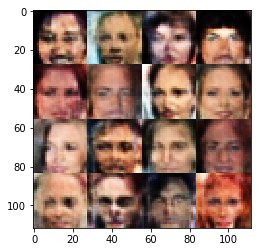

Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.5394


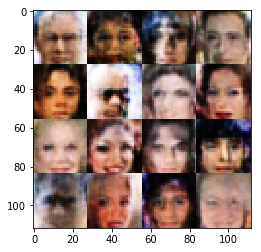

Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.1130


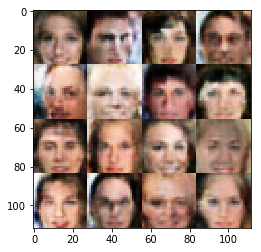

Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6819


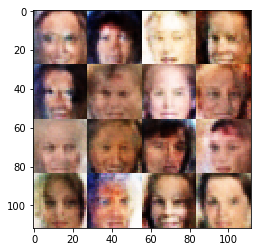

Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.0567


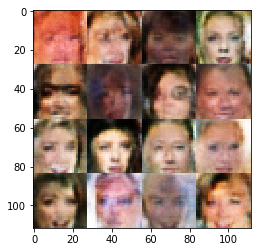

Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 0.8998


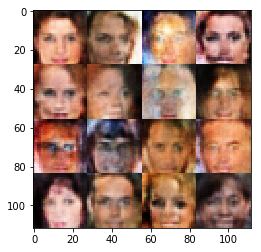

Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 0.6175... Generator Loss: 1.4227
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.6260


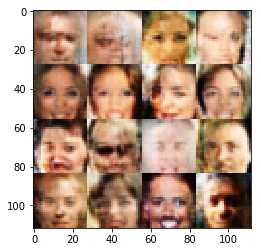

Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.4706
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.1043


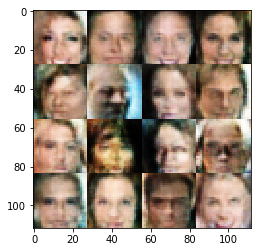

Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.0414


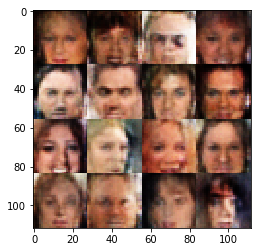

Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.1805
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.7318


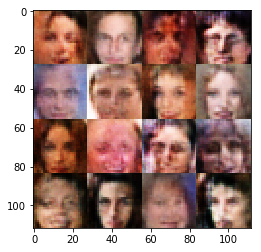

Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 1.0391


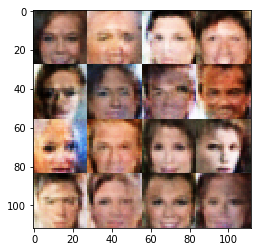

Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 1.5201
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.5763


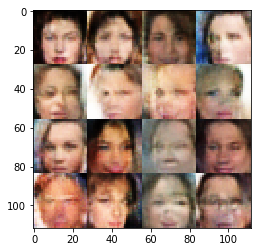

Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 0.8733


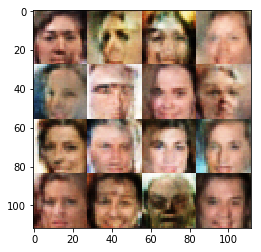

Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.6086
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.0375


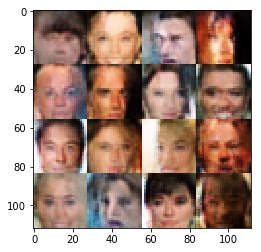

Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.5530


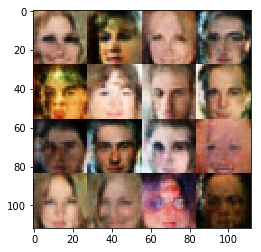

Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.4508


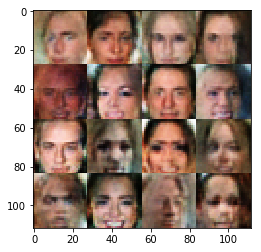

Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 1.6325
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.5151


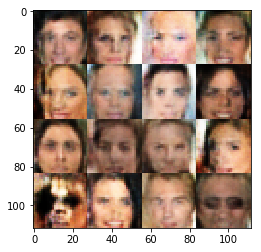

Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.2477
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.4113
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 0.7687


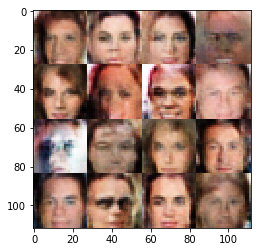

Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.5482


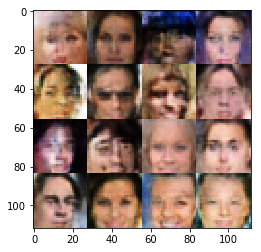

Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.3840
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 0.6846


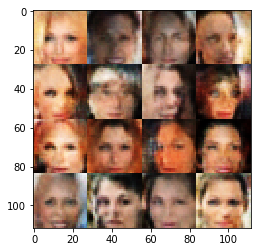

Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.6057
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.0581


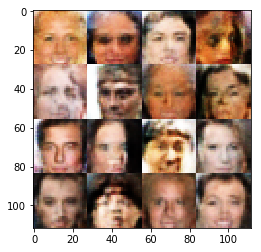

Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.3324
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.2046


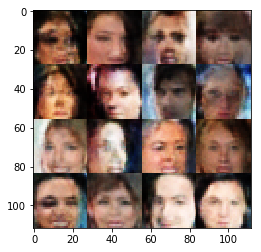

Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.3071
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.6756


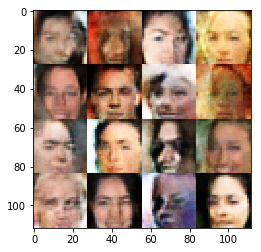

Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.2275
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 0.9432


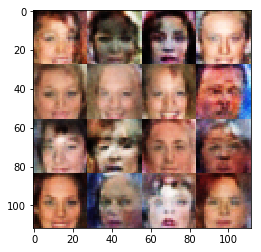

Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 1.4843
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 0.9660


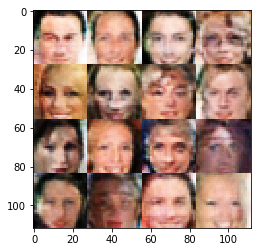

Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.3445
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.4703


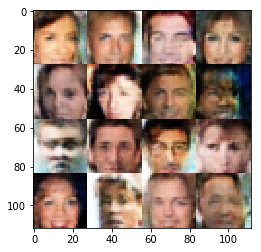

Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.6511


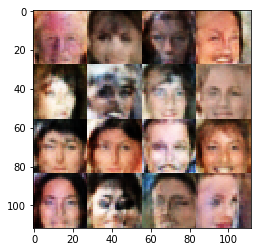

Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.2863
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 0.8742


In [16]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.